# Diffraction Limit Simulation

Simulating the output of a prime focus telescope given an input image. 

## Kitt Peak 2.1m Telescope
From http://www-kpno.kpno.noao.edu/kpno-misc/2m_params.html, this telescope has the following specs:

- Diameter = 2133.0mm
- Radius of curvature = 11168.4mm
 - Effective Focal Length = R/2 = 5584mm
 - Focal Ratio = 5584/2133 = f\2.63

From http://www.jdso.org/volume11/number1s/Genet_234_244.pdf, telescope was set up differently for speckle observation. Adding secondary mirror :

- Primary Diameter = 2.1m = 2133.0mm
- Focal Ratio = f/7.6
 - Focal Length = 2133.0mm*7.6 = 16211mm
- 8x Barlow
 - Focal Ratio = f/(7.6*8) = f/60.8
 - Focal Length = 16211mm*8 = 129.69m

## Andora Luca-R
From https://www.andor.com/pdfs/specifications/Andor_Luca-R_604_Specifications.pdf

- Sensor Size = 1004 (H) x 1002 (V) Pixels = 8mm X 8mm
 - Simplifying to 1000 x 1000 Pixels
- Pixel Size = 8um X 8um
- Only center 512x512 pixels used

## Calcs:
- Input image is in units of angles, represents the full input field of view
    - This is re-sampled to image it on a pixel scale
        - $\hbox{image scale} = \frac{206262}{focal length} = \frac{206262arcsec}{129.69*10^{3}} = 1.59 \frac{arcsec}{mm} $
        - $\hbox{pixel scale} = 1.59 \frac{as}{mm} * 16*10^{-3} \frac{mm}{pixel} = 25.44 \frac{marcsec}{pixel}$
        - If sky input is in units of pixel scale [ex: 25.44 marcsec], then no re-sampling required
 
- Aperture is in length units [m]
    - Need to calculate the "effective" size of the aperture, taking into account effects of lens focal length and light wavelength:
        - $ \textrm{Effective Aperture Diameter}=\frac{(\textrm{Aperture Diameter})}{(\lambda)(\textrm{Focal Length})} $
        - $ D = \frac{(2.133m)}{(0.8*10^{-6}m)(129.69m)} = 20599 \frac{1}{m}$
    - This is the radius of a circle that gives the first null of the corresponding airy disc to be at $ r = \frac{1.22}{D} = \frac{1.22}{20599 \frac{1}{m}} = 59.34*10^{-6}m $
        - In pixels, this corresponds to $\frac{59.34*10^{-6}m}{8*10^{-6}} = 7.42 pixels $
    - To simulate the imaging sensor, we need the sample units of the FFT of our aperture image to be the size of a pixel. For Andora Luca-R, pixel is 8um. Each sample of a 2D FFT represents 2/L (L = total sample size of input image). So we want total spatial sampling range = $\frac{1}{L} = 8*10^{-6} -> L = \frac{1}{8*10^{-6}} = 125*10^{3}$
        - If this is sampled with 512 pixels, each pixel represents $\frac{125*10^{-3}}{512} = 244.14 \frac{1}{m}$. So the diameter of the aperture = $D_{s} = \frac{20599}{244.14} = 84pixels$
    - The FFT of this is calculated, PSF is calculated as square of magnitude
    - Sanity check: first null occurs at 7 pixels away from center (256)
 
- Input and aperture PSF are convolved


In [1]:
#### Includes
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift
from scipy.signal import fftconvolve
from scipy.signal import argrelextrema
from scipy.misc import imresize

%matplotlib inline

# Image specs
nxy = 512
center = int(nxy/2)

## Creating Binary Star Input Image
# For KP 2.1m telescope, input image is in units of 25.44 milliarcseconds
platescale = 0.02544 # Plate scale in arcsec/pixel
rho = 0.5 # Set separation in arcseconds
phi = 0 # Set angle in degrees
# Calculate coordinates of stars
x = int( rho/(2*platescale) * np.cos(np.deg2rad(phi)) )
y = int( rho/(2*platescale) * np.sin(np.deg2rad(phi)) )
x1 = center + x
y1 = center + y
x2 = center - x
y2 = center - y    
# Empty input image
input_img = np.zeros((nxy,nxy)) 
# Place stars on image
input_img[y1,x1] = 1 
input_img[y2,x2] = 1
# Scale image power to 1
input_img_power = np.sum(np.power(input_img,2))
input_img = np.divide(input_img,np.sqrt(input_img_power))

## Calculate scaling factors for sampled aperture image
diameter_m = 2.133 # Mirror diameter in [m]
pixel = 8E-6 # Dimension of a pixel
focal_length = 129.69 # Effective focal length in meters
wavelength = 0.8E-6 # Wavelength of light

# Total spatial sample range
X_aperture_s = 1/pixel 
# dx value for sampled aperture image
dx_aperture_s = X_aperture_s/nxy 
# Coordinates of sampled image
x_aperture_s = np.arange(0,X_aperture_s,dx_aperture_s) - X_aperture_s/2
# Meshgrid of sampled coordinates
xx_s,yy_s = np.meshgrid(x_aperture_s,x_aperture_s)
# Scaled aperture diameter to effectively resample aperture image
diameter_s = diameter_m/(focal_length*wavelength)
# Draw new circle at correct dimensions
# Calculate grid of distances from circle center
circle_s = (xx_s) ** 2 + (yy_s) ** 2 
# Draw boolean circle
circle_s = circle_s < (diameter_s/2)**2 
# Convert boolean circle to int
circle_s= circle_s.astype(np.int64)
# Save aperture image in units of meters
aperture_screen_s = circle_s
# Scale aperture image power to 1
aperture_screen_power = np.sum(np.power(aperture_screen_s,2))
aperture_screen_s = np.divide(aperture_screen_s,np.sqrt(aperture_screen_power))
# Calculate effective size of sampled aperture image in meters
X_aperture_s_meff = focal_length*wavelength/pixel

## Calculate Output Images
# Calculate normalized complex diffraction pattern
aperture_psf = fftshift(fft2(aperture_screen_s))
# Calculate PSF of complex diffraction pattern
aperture_psf = np.power(np.abs(aperture_psf),2)
# Scale PSF power to 1
aperture_psf_power = np.sum(np.power(aperture_psf,2))
aperture_psf = np.divide(aperture_psf,np.sqrt(aperture_psf_power))
# Convolve PSF with input image
sensor_img = fftconvolve(input_img,aperture_psf)
# Save the center nxy by nxy image
sensor_img = sensor_img[center:center+nxy,center:center+nxy] 

Aperture PSF Null Radii
7
14
20
26
32


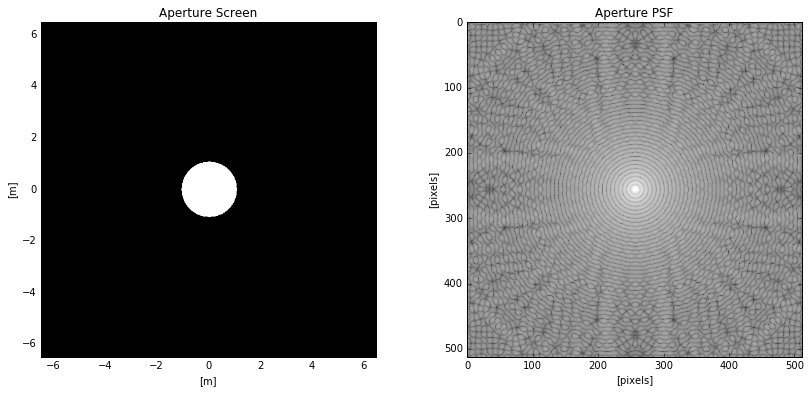

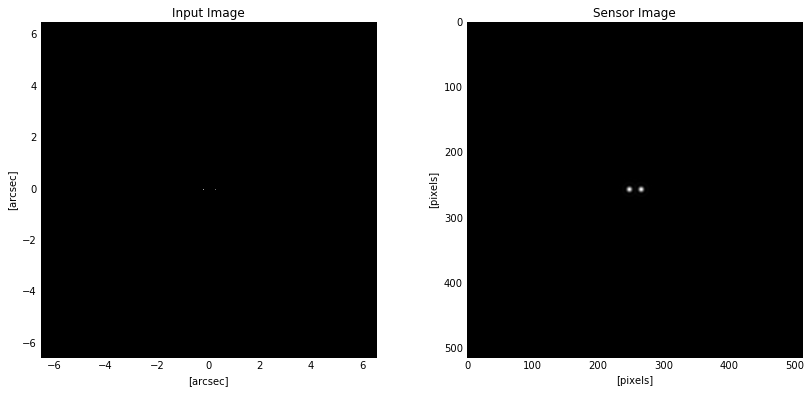

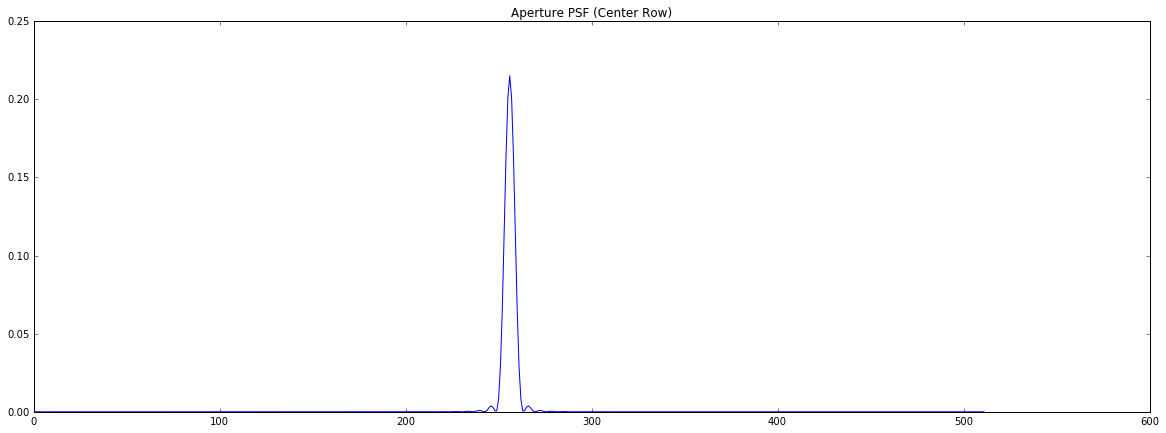

In [2]:
#Plots
colormap = "gray"


plt.figure(figsize = (14,6), dpi = 100)
plt.subplot(1,2,1)
plt.imshow(aperture_screen_s, cmap=colormap, 
           extent = (-X_aperture_s_meff/2,X_aperture_s_meff/2,
                     -X_aperture_s_meff/2,X_aperture_s_meff/2))
plt.xlabel("[m]")
plt.ylabel("[m]")
plt.title("Aperture Screen")

plt.subplot(1,2,2)
plt.imshow(np.log10(aperture_psf), cmap=colormap)
plt.xlabel("[pixels]")
plt.ylabel("[pixels]")
plt.title("Aperture PSF")

plt.figure(figsize = (14,6), dpi = 100)
plt.subplot(1,2,1)
#plt.imshow(input_img, cmap=colormap, extent = (-6.513,6.513,-6.513,6.513))
plt.imshow(input_img, cmap=colormap, extent = (-nxy*platescale/2,nxy*platescale/2,
                                               -nxy*platescale/2,nxy*platescale/2))
plt.xlabel("[arcsec]")
plt.ylabel("[arcsec]")
plt.title("Input Image")

plt.subplot(1,2,2)
plt.imshow(sensor_img, cmap=colormap)
plt.xlabel("[pixels]")
plt.ylabel("[pixels]")
plt.title("Sensor Image")

# Show center row of aperture PSF and sensor's image
plt.figure(figsize = (20,7), dpi = 100)
plt.plot((aperture_psf[center,:]))
plt.title("Aperture PSF (Center Row)")

# List distances from center of nulls in PSF
print("Aperture PSF Null Radii")
minima_i = np.subtract(argrelextrema(aperture_psf[center], np.less),center)[0]
print_num = 5
minima_found = 0
for value in minima_i:
    if (value > 0) and (minima_found < print_num):
        print(value)
        minima_found = minima_found + 1

0 1.26287869051e-15
1 3.34428082317e-15
2 100.0
3 7.09370917492e-15
4 6.78366562398e-15
5 5.7128876621e-15
6 4.77179171191e-15
7 2.64286389125e-15
8 2.52660451568e-15
9 1.78714044616e-15
10 2.40431644547e-15
11 1.91812672557e-15
12 1.72804538246e-15
13 2.74398907365e-15
14 1.36267279504e-15
15 2.06336436879e-15
16 1.33128301388e-15
17 1.59882211422e-15
18 2.5765701789e-15
19 1.24922942645e-15


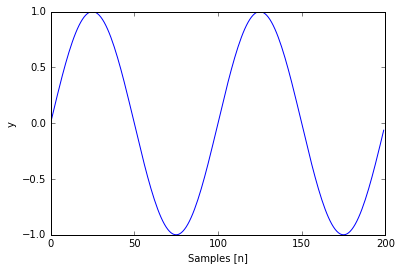

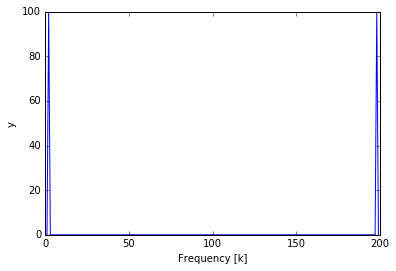

In [3]:
# FFT Sanity Check
from scipy.fftpack import fft

# Continuous Signal: y = sin(2pi*t) [Frequency = 1Hz]
# Sample this signal with sample time = 0.01s : y = sin(2pi*0.01n)
# To sample it for 2 seconds, we will have n = 0:200
n = np.arange(200)
y = np.sin(2*np.pi*0.01*n)

plt.figure()
plt.plot(n,y)
plt.xlabel("Samples [n]")
plt.ylabel("y")

# We take the FFT of this signal
# We know that all the energy of this signal should be at 1Hz
# Each index of FFT = k/T = k/2 = 0.5k Hz

y_f = fft(y)

plt.figure()
plt.plot(n,np.abs(y_f))
plt.xlabel("Frequency [k]")
plt.ylabel("y")

for i in np.arange(20):
    print(i,np.abs(y_f[i]))
    
# As expected, we see a peak at k = 2, which corresponds to f = 0.5(2) = 1Hz